$\large \text{REQUIREMENT 2: MULTIPLE PRODUCTS AND STOCHASTIC ENVIRONMENT}$

Build a pricing strategy using Combinatorial-UCB with the inventory constraint.

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import uniform
import itertools
from joblib import Parallel, delayed

In [2]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    def __init__(self,T,N, prices, costs):

        
        #Time horizon
        self.T=T
        
        #Set of possible prices
        self.prices=prices
        
        #Number of products
        self.N=N  
        
        #Valuations of each product are indipendent uniformly distributed random variabiles. 
        #Each distribution has a different mean and a different domain 
        #REMARK: the domain is a subset of [0,1]
        
        self.valuations = np.zeros((self.N, self.T)) 
        sell_probabilities_list = []

        means = np.linspace(0.2, 0.8, self.N)   # Vector of the means of the N distributions
        L = 0.4  # Width of the intervals of the distributions

        #Generate valuations and selling probabilities
        for n,mu in enumerate(means):
            low = max(0, mu - L/2)
            high = min(1, mu + L/2)           
            dist = uniform(loc=low, scale=high - low) 

            for t in range(self.T):
                self.valuations[n, t] = dist.rvs()
            
            sell_probs = 1 - dist.cdf(prices)
            sell_probabilities_list.append(sell_probs)

        
        #Matrix containing in each row the vectors sell_prob for each one of the N products
        self.sell_probabilities_matrix = np.vstack(sell_probabilities_list)  
        
        #Current round
        self.t = 0
        
        #Production costs
        self.production_costs=costs

    def round(self, p_t_vector):

        s_t_vector = np.zeros(self.N, dtype=int)
        f_t_vector = np.zeros(self.N)
        
        #No selling procedure
        if  np.all(p_t_vector == -1):
            return s_t_vector, f_t_vector

        else:
            for i in range(self.N):

                #If the buyer buys the product we return 1 (0 othewise)
                s_t_vector[i] = int(self.prices[p_t_vector[i]] < self.valuations[i, self.t])

                #Chosen price
                price = self.prices[p_t_vector[i]]

                #Utility
                f_t_vector[i] = (price - self.production_costs[i]) * s_t_vector[i]

            #Update the current round
            self.t += 1
            
            return s_t_vector, f_t_vector    


In [3]:
############################################################ CLASS SELLER ###################################################################################################################

class UCBLikeSeller():
    
    def __init__(self, K, stock, T, N, range=1):
        
        #Number of prices
        self.K = K
        
        #Time horizon
        self.T = T
        
        #Number of products
        self.N=N
        
        #Scaling factor (set as 1)
        self.range = range
        
        #Chosen superarm (set of indices)
        self.p_t_vector = np.zeros(self.N, dtype=int) 
        
        #Average utility matrix
        self.avg_f = np.zeros((self.N, K), dtype=float)
        
        #Matrix of average selling results 
        self.avg_s = np.zeros((self.N, K), dtype=float)
        
        #Matrix of number of pulls per prices
        self.N_pulls =  np.zeros((self.N, K), dtype=int)

        #Stock
        self.stock = stock
        
        #Budget per round
        self.rho = self.stock/T 
        
        #Current round
        self.t = 0
        
        #Auxiliary vector used to update after having used a superarm
        self.cols_t=np.zeros(self.N)
        
    def pull_arm(self):
        
        #Matrices used to store UCBs of utilities and LCBs of selling results respectively
        UCB_matrix_t = np.zeros((self.N, self.K), dtype=float)   
        LCB_matrix_t=np.zeros((self.N, self.K), dtype=float)

        #No selling procedure: no more stock available
        if self.stock < self.N:  
            
            self.p_t_vector=np.full(self.N, -1)
            
            return self.p_t_vector
        
        #Exploration
        if self.t < self.K:
            self.p_t_vector= np.full(self.N, self.t)
            self.cols_t = self.p_t_vector.astype(int)
            
        else:

            UCB_matrix_t = self.avg_f + self.range * np.sqrt(2*np.log(self.T)/self.N_pulls)
            LCB_matrix_t = self.avg_s - self.range * np.sqrt(2*np.log(self.T)/self.N_pulls)

            #List of vectors: list of all the possible superarms
            possible_superarms = list(itertools.product(range(self.K), repeat=self.N))
            number_of_possible_superarms = len(possible_superarms)
            s_lcb_super = np.array([])
            f_ucb_super = np.array([])
            
            #UCBs of the utilities and LCBs of the selling results related to the superarms
            for C in possible_superarms :
                R=np.arange(self.N)
                
                f_ucb_super=np.append(f_ucb_super, np.sum(UCB_matrix_t[R, C]))
                s_lcb_super=np.append(s_lcb_super, np.sum(LCB_matrix_t[R,C]))
                

            else:
                #Linear program to retrive a distribution 
                f = -f_ucb_super
                A_ub = [s_lcb_super]
                b_ub = [self.rho]  
                A_eq = [np.ones(number_of_possible_superarms)]
                b_eq = [1]
                res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
                gamma = res.x
                
                #Sample the price using the distribution previously obtained
                index_p_t_vector = np.random.choice(number_of_possible_superarms, p=gamma)
                self.p_t_vector = np.array(possible_superarms[index_p_t_vector], dtype=int)

            #Update cols_t
            self.cols_t = self.p_t_vector.astype(int) 

        return self.p_t_vector


    def update(self, s_t_vector, f_t_vector):
        
        
        cols = self.cols_t.astype(int)              
        rows = np.arange(self.N)                    

        #Update the matrix of the number of pulls
        self.N_pulls[rows, cols] += 1
        
        #Update the matrix of the average utilities
        self.avg_f[rows, cols] += (f_t_vector - self.avg_f[rows, cols]) / self.N_pulls[rows, cols]
        
        #Update the matrix of the average selling results
        self.avg_s[rows, cols] += (s_t_vector - self.avg_s[rows, cols]) / self.N_pulls[rows, cols]

        #Decrease the stock
        self.stock -= np.sum(s_t_vector)
        
        #Update the current round
        self.t += 1


In [4]:
############################################################ CLAIRVOYANT ###################################################################################################################

def compute_clairvoyant(N, K, prices, production_costs, rho, sell_probabilities):
    
    #OUTPUT: clairvoyant utility
    
    OPT=0
    
    #List of vectors: list of all the possible superarms
    possible_superarms = list(itertools.product(range(K), repeat=N))
    number_of_possible_superarms = len(possible_superarms)
    
    exp_s_super = np.array([])
    exp_f_super = np.array([])
    
    #Utilities and selling results related to the superarms 
    #REMARK: sell_probabilities are used to make reasonings in expectation
    for C in possible_superarms :
        
        R=np.arange(N)
        exp_s_super=np.append(exp_s_super, np.sum(sell_probabilities[R,C]))
        exp_f_super=np.append(exp_f_super, np.sum((prices[np.array(C)] - production_costs) * sell_probabilities[R, C]))
                

    #Linear Program
    f = -(exp_f_super)
    A_ub = [exp_s_super]
    b_ub = [rho]  
    A_eq = [np.ones(number_of_possible_superarms)]
    b_eq = [1]
    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    
    OPT=-(res.fun)

          
    return  OPT

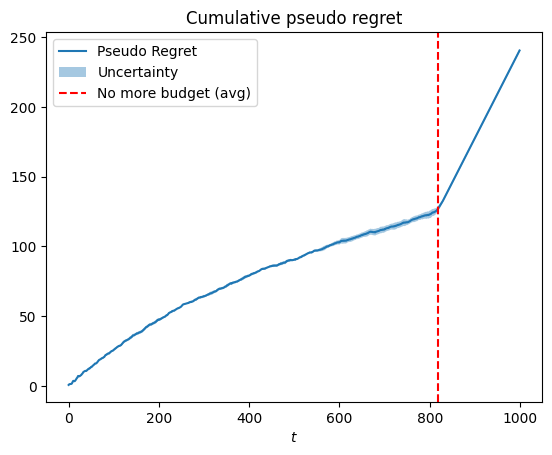

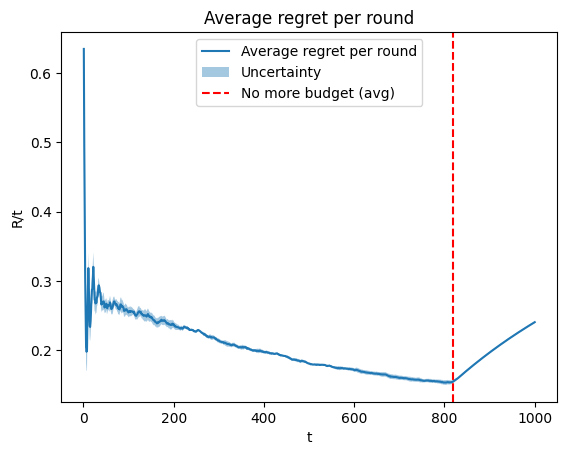

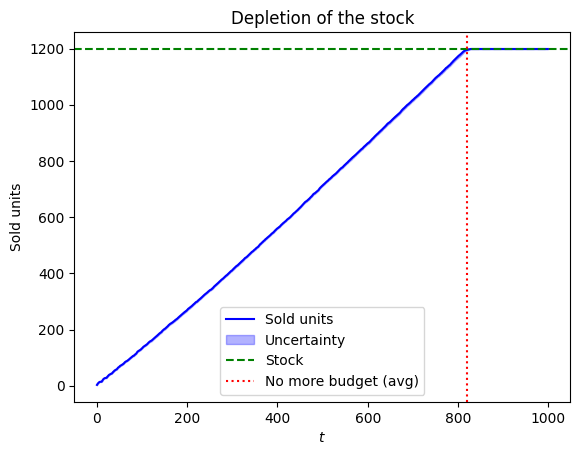

In [5]:
############################################################ EXPERIMENT ###################################################################################################################

#Setting
N = 3
T = 1000  
prices = np.linspace(0.1, 1.1, 11)
c = 0.1 * np.ones(N)
K = len(prices)
stock = 1200
rho = stock / T
n_trials = 5
regret_per_trial = []


#CLAIRVOYANT
means = np.linspace(0.2, 0.8, N)   
L = 0.4  

sell_probabilities_list = []
for mu in means:
    low = max(0, mu - L/2)
    high = min(1, mu + L/2)           
    dist = uniform(loc=low, scale=high - low)  
    sell_probs = 1 - dist.cdf(prices)
    sell_probabilities_list.append(sell_probs)

sell_probabilities_matrix = np.vstack(sell_probabilities_list) 
OPT = compute_clairvoyant(N, K, prices, c, rho, sell_probabilities_matrix)


#Function to be parallelized
def run_single_trial(seed=None):
    if seed is not None:
        np.random.seed(seed)  #OPTIONAL: seed for reproducibility
    
    ucb_seller = UCBLikeSeller(K, stock, T, N, range=1)
    env = buyer(T, N, prices, c)

    seller_utilities = np.array([])
    products_sold = np.array([])
    exhausted_at = T   

    # Experiment
    for u in range(T):
        vect_p_t = ucb_seller.pull_arm()        
        if np.all(vect_p_t == -1): 
            exhausted_at = u   
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)

            ucb_seller.update(vect_s_t, vect_f_t)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)
            
    if len(seller_utilities) < T:
        seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
    if len(products_sold) < T:
        products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
    
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)

    return cumulative_regret, exhausted_at, products_sold


#Parallelization of the trials
results = Parallel(n_jobs=-1)(delayed(run_single_trial)(seed) for seed in range(n_trials))

#Results
regret_per_trial, exhaustion_times, products_sold_trials = zip(*results)
regret_per_trial = np.array(regret_per_trial)
products_sold_trials = np.array(products_sold_trials)

#Mean and standard deviation of the regret 
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
cumulative_sold_trials = np.array([np.cumsum(p) for p in products_sold_trials])
avg_cumulative_sold = cumulative_sold_trials.mean(axis=0)
cumulative_sold_sd = cumulative_sold_trials.std(axis=0)

############################################################ PLOTS ###################################################################################################################

#Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.title('Cumulative pseudo regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.xlabel('$t$')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')

plt.legend()
plt.show()


#Plot 2: Average Regret per round 
times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round')
plt.title('Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')

plt.xlabel('t')
plt.ylabel('R/t')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()


#Plot 3: Number of units sold vs time with confidence intervals
plt.plot(np.arange(T), avg_cumulative_sold, label="Sold units", color="blue")
plt.fill_between(np.arange(T),
                 avg_cumulative_sold - cumulative_sold_sd/np.sqrt(n_trials),
                 avg_cumulative_sold + cumulative_sold_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.3, label="Uncertainty")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')

avg_exhaustion_time = int(np.mean(exhaustion_times))
plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')

plt.xlabel("$t$")
plt.ylabel("Sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()
